In [2]:
import torch
import torchvision
import torchaudio 
import os
import torch.nn as nn
from os.path import isfile, join, isdir, exists
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
class MusicDataset(Dataset):

    def __init__(self, spec_dir, out_dir, years):
        self.spec_dir = spec_dir
        self.out_dir = out_dir
        self.ims = []
        self.labels = []
        self.names = []

        for dirs in years:
            for f in os.listdir(join(spec_dir, dirs)):
                if(isfile(join(join(out_dir, dirs), f))):
                    self.ims.append(join(join(spec_dir, dirs), f))
                    onm = join(out_dir, dirs)
                    self.labels.append(join(onm, f))
                    self.names.append(join(join(out_dir, dirs), f))
                    #print(join(join(spec_dir, dirs), f))
                    #print(join(onm, f))

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        #print(self.ims[idx])
        
        im, lab = torch.load(self.ims[idx]), torch.load(self.labels[idx])
        if(im.isnan().any()):
            print(self.names[idx])
        mean = torch.mean(im)
        std = torch.std(im)
        if(std==0):
            im = torch.zeros_like(im)
        else:
            im = (im-mean)/(std)

        if(im.isnan().any()):
            print(self.names[idx], "post", mean, std)
            im = torch.zeros_like(im)

        return im, lab

bs = 32
training_data = MusicDataset('mel/', 'mid/', ['2004', '2006', '2008', '2009', '2011', '2013', '2014'])
test_data = MusicDataset('mel/', 'mid/', ['2015', '2017', '2018'])
train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True, )
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=False)

In [4]:
# 229 x 1001 input
# 88 x 7681 output

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.ds1 = dsResConvBlock(1, 16)
        self.ds2 = dsResConvBlock(16, 64)
        self.cnn1 = nn.Conv2d(64, 64, 3, 1, padding='same')
        self.cnn2 = nn.Conv2d(64, 64, 3, 1, padding='same')
        self.us1 = usResConvBlock(64, 16)
        self.us2 = usResConvBlock(32, 4, out_size = (88, 7680+5))
        self.ReLU = nn.Tanh()
        self.conv1 = nn.Conv1d(352, 88, 6)
        #self.linear = nn.Linear(4*6*88, 88)

    def forward(self, x):
        y = self.ds1(x)
        res1 = y
        y = self.ds2(y)
        res2 = y
        y = self.cnn1(y)
        y = self.ReLU(y)
        y = self.cnn2(y)
        y = self.ReLU(y + res2)
        y = self.us1(y)
        # print(y.shape, res1.shape)
        y = torch.cat((res1, y), axis=1)
        y = self.us2(y)
        output = self.conv1(y.reshape(-1, 4*88, 7685))
        output = nn.Sigmoid()(output)
        #output = torch.zeros((y.shape[0], 88, 7680)).to('cuda')
        # print(y.shape)
        # for i in range(7680):
        #     # print(y[:, :, :, i:i+6].shape)
        #     tp = y[:, :, :, i:i+6].reshape(-1, 4*6*88)
        #     # print(tp.shape)
        #     output[:, :, i] = nn.Sigmoid()(self.linear(tp))
        
        return output


class dsResConvBlock(nn.Module):
    def __init__(self, num_in, num_out):
        super(dsResConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_in, num_out, (3, 3), (1,1), padding='same')
        self.conv2 = nn.Conv2d(num_out, num_out, (3, 3), (1,1), padding='same')
        self.bn = nn.BatchNorm2d(num_out, momentum=0.9, eps=1e-5)
        self.mp = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.ReLU = nn.Tanh()

    def forward(self, x):
        residual = self.ReLU(self.conv1(x))
        y = (self.conv2(residual))
        #y = self.bn(y)
        y = self.ReLU(y + residual)
        y = self.mp(y)
        return y

class usResConvBlock(nn.Module):
    def __init__(self, num_in, num_out, out_size = (1,1)):
        super(usResConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_in, num_out, (3, 3), (1,1), padding='same')
        self.conv2 = nn.Conv2d(num_out, num_out, (3, 3), (1,1), padding='same')
        self.bn = nn.BatchNorm2d(num_out, momentum=0.9, eps=1e-5)
        self.ReLU = nn.Tanh()
        self.out_size = out_size

    def forward(self, x):
        # print("forward 1", x.shape)
        residual = self.ReLU(self.conv1(x))
        y = (self.conv2(residual))
        y = self.ReLU(y + residual)
        # print("forward 2", y.shape)
        if(self.out_size == (1,1)):
            # print("s\n")
            y = nn.Upsample(scale_factor = 2, mode='bilinear')(y)
        else:
            # print("a\n", self.out_size)
            y = nn.Upsample(size = self.out_size, mode='bilinear')(y)
        # print("foward 3")


        return y

def loss_func(x, y):
    # metric = nn.BCELoss()
    # return metric(x.flatten(), (y.flatten()))
    x = torch.clip(x, min=1e-20, max=1-1e-20)
    if(x.isnan().any()):
        print("ANSH IS A GOON!")
    #return torch.mean(y*torch.log(x)*0.95 + (-1*y+1)*torch.log(-1*x+1)*0.05)*-1
    return torch.mean(y*torch.log(x)*0.2/0.05 + (-1*y+1)*torch.log(-1*x+1) * 0.8/0.95)*-1
# a = torch.zeros((5, 5))
# y = torch.ones((5, 5))*0
 
# print(loss_func(a, y))

In [4]:
checkpoint = torch.load('cnn_run_reweight_2_81560.pt')

model = Model()
model = model.to('cuda')
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

model.load_state_dict(checkpoint['model_state_dict'])

lr = 3e-4
optim = torch.optim.Adam(lr = lr, params = model.parameters())

optim.load_state_dict(checkpoint['optimizer_state_dict'])
save_epochs = 1
val_print_ep = 5
n_epochs = 100
losses = []
for i in range(1):
    print("starting epoch", i)
    total_loss = 0
    batch = 0
    intlosses = []
    for X, y in train_dataloader:
        # print("batch progress", batch, len(train_dataloader))
        batch += 1
        if(batch % 300 == 0):
            print(batch, intlosses[-1])
            torch.save({
            'epoch': i,
            'batch': batch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': intlosses,
            }, 'cnn_run_reweight_2_8_1_' + str(batch) + '.pt')
        
        X = torch.unsqueeze(X, axis = 1)
        X = X.to('cuda')
        if(X.isnan().any()):
            print("HI")
        # print(X.shape)
        y = y.type(torch.float32).to('cuda')
        optim.zero_grad()
        pred = model(X)
        loss = loss_func(pred, y)
        # print(loss.item())
        intlosses.append(loss.item())
        ##print(intlosses)
        total_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optim.step()
    losses.append(total_loss)
    print(total_loss)
    if (i % save_epochs == 0):
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses,
            }, 'saved_data.pt')

    # if (i % val_print_ep == 0):
    #     with torch.no_grad():
    #         total_loss = 0
    #         for X, y in test_dataloader:
    #             X = torch.unsqueeze(X, axis = 1)
    #             X = X.to('cuda')
    #             y = y.to('cuda')
    #             pred = model(X)
    #             loss = loss_func(y, pred)
    #             total_loss += loss
    #     print("Test error after epoch " + str(i) + ": " + str(total_loss/len(test_dataloader)))

321544
starting epoch 0
300 0.10711944848299026
600 0.09701274335384369
900 0.09207046777009964
1200 0.09755636006593704
mid/2014/MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_04_R3_2014_wav--1_70.pt post tensor(-inf) tensor(nan)
1500 0.08794832229614258
147.9308992549777


torch.Size([229, 1001])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[0.0016, 0.0016, 0.0016,  ..., 0.0003, 0.0003, 0.0003],
         [0.0024, 0.0024, 0.0024,  ..., 0.0005, 0.0005, 0.0005],
         [0.0016, 0.0016, 0.0016,  ..., 0.0003, 0.0003, 0.0003],
         ...,
         [0.0011, 0.0011, 0.0011,  ..., 0.0002, 0.0002, 0.0002],
         [0.0017, 0.0017, 0.0017,  ..., 0.0002, 0.0002, 0.0002],
         [0.0016, 0.0016, 0.0016,  ..., 0.0003, 0.0003, 0.0003]]]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.9949)


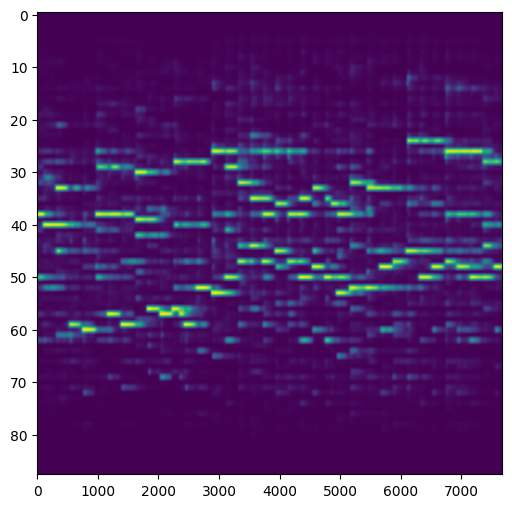

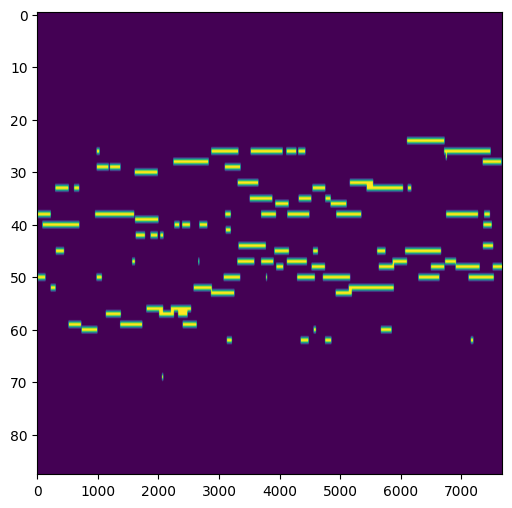

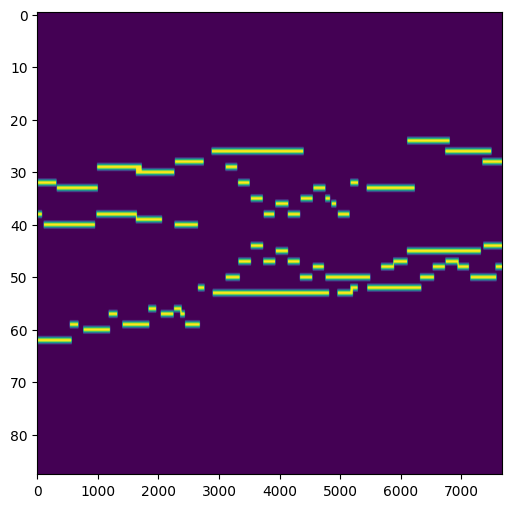

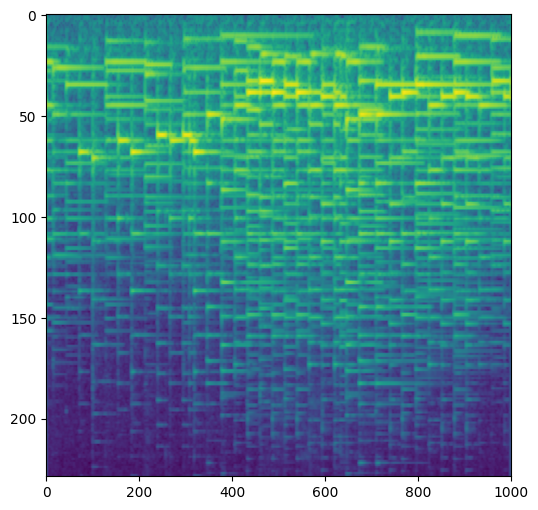

In [27]:
tt = DataLoader(test_data, batch_size=1, shuffle=False)
meval = Model()
checkpoint = torch.load('cnn_run_reweight_2_8300.pt')
meval.load_state_dict(checkpoint['model_state_dict'])
meval.eval()
#model_parameters = filter(lambda p: p.requires_grad, model.parameters())
#params = sum([np.prod(p.size()) for p in model_parameters])
#print(params)
fname = "mel/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
X = torch.load(fname)
X = (X - torch.mean(X))/torch.std(X)
print(X.shape)
fname = "mid/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
y = torch.load(fname).type(torch.float32)
X = torch.unsqueeze(X, axis = 0)
X = torch.unsqueeze(X, axis = 0)

# X = X.to('cuda')
# y = y.to('cuda')
# print(nn.CrossEntropyLoss()(y, pred[0, :, :]))

with torch.no_grad():    
    pred = meval(X).to('cpu')
    #print(nn.BCELoss()(pred[0, :, :], y))

print(np.round(pred.to('cpu')))

# np.save('predcnn28_2.npy', np.round(pred.to('cpu')))
#np.save('realcnn_2.npy', np.round(pred.to('cpu')))

print(pred, y)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(pred[0, :, :], aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.round(pred[0, :, :]), aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(y, aspect='auto')
# print(y.shape, pred.shape)
# fig, ax = plt.subplots(figsize=(6,6))   
# ax.plot(checkpoint['loss'])
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(X[0, 0, :, :], aspect='auto')
print(torch.max(pred))


In [6]:
def evaluate(model, dataloader):
    model.eval()
    model.to('cuda')
    p = []
    r = []
    f = []
    a = []
    batch = 0
    with torch.no_grad():
        for X, y in dataloader:
            print("batch " + str(batch) + " of " + str(len(dataloader)))
            batch+=1
            X = torch.unsqueeze(X, axis = 1)
            X = X.to('cuda')
            y = y.type(torch.float32).to('cuda')
            optim.zero_grad()
            pred = model(X)
            pred = torch.round(pred)
            # print(torch.where(pred==1))
            # guessed_p = (pred==1)
            # actual_p = (y==1)
            # tp = (guessed_p == actual_p)
            
            precision = torch.sum(torch.logical_and(pred==1, y==1).type(torch.float32))/torch.sum((pred==1).type(torch.float32))
            recall = torch.sum(torch.logical_and(pred==1, y==1).type(torch.float32))/torch.sum((y==1).type(torch.float32))
            acc = torch.mean((pred==y).type(torch.float32))
            f1 = (precision*recall)/(precision+recall)
            p.append(precision.item())
            r.append(recall.item())
            f.append(f1.item())
            a.append(acc.item())
            print(p[-1], r[-1], f[-1], a[-1])
    return p, r, f, a

tt = DataLoader(test_data, batch_size=32, shuffle=False)
p, r, f, a = evaluate(meval, tt)
print(np.mean(p), np.mean(r), np.mean(f), np.mean(a))

batch 0 of 646
0.4822896420955658 0.7882218360900879 0.29921117424964905 0.9750458598136902
batch 1 of 646
0.5450801849365234 0.802372395992279 0.3245808482170105 0.9782620072364807
batch 2 of 646
0.4878622591495514 0.8030378222465515 0.3034873604774475 0.9784311652183533
batch 3 of 646
0.4925217926502228 0.8473348617553711 0.3114742934703827 0.9781998991966248
batch 4 of 646
0.4987354278564453 0.8256606459617615 0.3109237551689148 0.9783198833465576
batch 5 of 646
0.48720481991767883 0.7559186220169067 0.2962595820426941 0.9754290580749512
batch 6 of 646
0.47391319274902344 0.8206865191459656 0.3004281222820282 0.9770662784576416
batch 7 of 646
0.4797373116016388 0.7805005311965942 0.2971147298812866 0.9770405888557434
batch 8 of 646
0.5254424810409546 0.8015133738517761 0.3173799514770508 0.9799060225486755
batch 9 of 646
0.5579411387443542 0.8076826333999634 0.32998794317245483 0.9814378023147583
batch 10 of 646
0.5134972929954529 0.822765588760376 0.31617122888565063 0.978525400161